## Import Libraries

In [1]:
import re
import sys
import time
import nltk
import spacy
import string
import wordninja
import numpy as np
import pandas as pd
import multiprocessing
from tqdm import tqdm
from sklearn.svm import SVC
from matplotlib import gridspec
from wordcloud import WordCloud

from gensim.models import Word2Vec
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from sklearn.metrics import log_loss
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.phrases import Phrases, Phraser, ENGLISH_CONNECTOR_WORDS
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
import warnings
from sklearn.ensemble import RandomForestClassifier

#initializers
tqdm.pandas()
lemma = WordNetLemmatizer()
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# pd.set_option('display.max_colwidth', -1)
# nltk.download('wordnet')

# !pip install wordninja
# pip install gensim
# !pip install spacy
# !{sys.executable} -m spacy download en #download en models
# !pip install wordcloud

### Load Data

In [242]:
df = pd.read_csv('train.csv')
df.drop(['Id'], axis=1,inplace=True)
df.shape

(6136, 13)

In [243]:
df.head(2)

Review  Components  \
0  For some reason everybody complains and I'm co...           0   
1  I like everything about it, great choice of sp...           0   

   Delivery and Customer Support  Design and Aesthetics  Dimensions  Features  \
0                              0                      0           0         0   
1                              0                      0           0         1   

   Functionality  Installation  Material  Price  Quality  Usability  Polarity  
0              0             0         0      0        0          1         0  
1              1             0         0      0        0          0         1

### Test Train split

In [314]:
#train test split
X = df[["Review"]]
Y = df[['Components', 'Delivery and Customer Support','Design and Aesthetics', 'Dimensions', 'Features', 'Functionality',
       'Installation', 'Material', 'Price', 'Quality', 'Usability', 'Polarity',]]
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.1,shuffle=False,random_state=92)
X_train.shape, X_test.shape

((5522, 1), (614, 1))

### Pre-processing

In [315]:
#remove punctuations, digits, double spaces, split combined words, lemmetization using pos
def prep(df):
    df.loc[:,"preprocessed"]= df["Review"].str.lower().str.translate(str.maketrans('\n',' ',string.punctuation)) 
    df.loc[:,"preprocessed"] = df["preprocessed"].apply(lambda x: re.sub('[0-9]+','',x))                         
    df.loc[:,"preprocessed"] = df["preprocessed"].apply(lambda x: re.sub(' +',' ',x))                            
    df.loc[:,"preprocessed"] = df["preprocessed"].apply(lambda x: ' '.join((' '.join([' '.join(wordninja.split(tok)) for 
                                                                    tok in x.split(' ')])).split(' ')))    
    df.loc[:,"prep_lem"] = df["preprocessed"].apply(lambda x: ([token.lemma_ for token in nlp(x)]))   
    return df

In [316]:
df_train = prep(X_train)
df_test = prep(X_test)

C:\Users\saido\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\saido\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [317]:
## Phraser model
bigram = Phrases(df_train["prep_lem"].values, min_count=10, threshold=10,connector_words=ENGLISH_CONNECTOR_WORDS)
trigram = Phrases(bigram[df_train["prep_lem"].values], min_count=5, threshold=1,connector_words=ENGLISH_CONNECTOR_WORDS,scoring='npmi')
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

In [318]:
#apply on tokens for train
df_train.loc[:,'bigram_tokens'] = df_train['prep_lem'].apply(lambda x: bigram_mod[x])
df_train.loc[:,'trigram_tokens'] = df_train['prep_lem'].apply(lambda x: trigram_mod[x])

# test
df_test.loc[:,'bigram_tokens'] = df_test['prep_lem'].apply(lambda x: bigram_mod[x])
df_test.loc[:,'trigram_tokens'] = df_test['prep_lem'].apply(lambda x: trigram_mod[x])

In [321]:
#stopword list
comment_words = [j for i in df_train.bigram_tokens.values for j in i if not len(j)>2 ] +['easy','good','great','use']
stop_wrd_li = [re.sub('[^a-z]','',i) for i in stopwords.words('english')] + comment_words 
def stop_word(df,stop_wrd_li):
    df.loc[:,'bigram_tokens'] = df['bigram_tokens'].progress_apply(lambda x: ' '.join([tok for tok in x if tok not in stop_wrd_li]) )
    df.loc[:,'trigram_tokens'] = df['trigram_tokens'].progress_apply(lambda x: ' '.join([tok for tok in x if tok not in stop_wrd_li]) )
    return df

In [323]:
df_train = stop_word(df_train,stop_wrd_li)
df_test = stop_word(df_test,stop_wrd_li)

100%|██████████| 614/614 [00:10<00:00, 59.81it/s]


### load pre processed data

In [2]:
df_train = pd.read_pickle("train.pkl")  
df_test = pd.read_pickle("test.pkl")  
y_train = pd.read_pickle("y_train.pkl")
y_test = pd.read_pickle("y_test.pkl")
df_train['bi_w2v'] = df_train['bigram_tokens'].apply(lambda x: x.split(' '))
df_test['bi_w2v'] = df_test['bigram_tokens'].apply(lambda x: x.split(' '))

In [3]:
df_train = df_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

df_test = df_test.reset_index(drop=True)
y_test= y_test.reset_index(drop=True)

In [4]:
y_test.shape, df_test.shape, df_train.shape , y_train.shape

((614, 12), (614, 6), (5522, 6), (5522, 12))

### Wordcloud for Stop word Manipulation
* Removed common words accorss all the Topics
* removed the words with less than len 2.

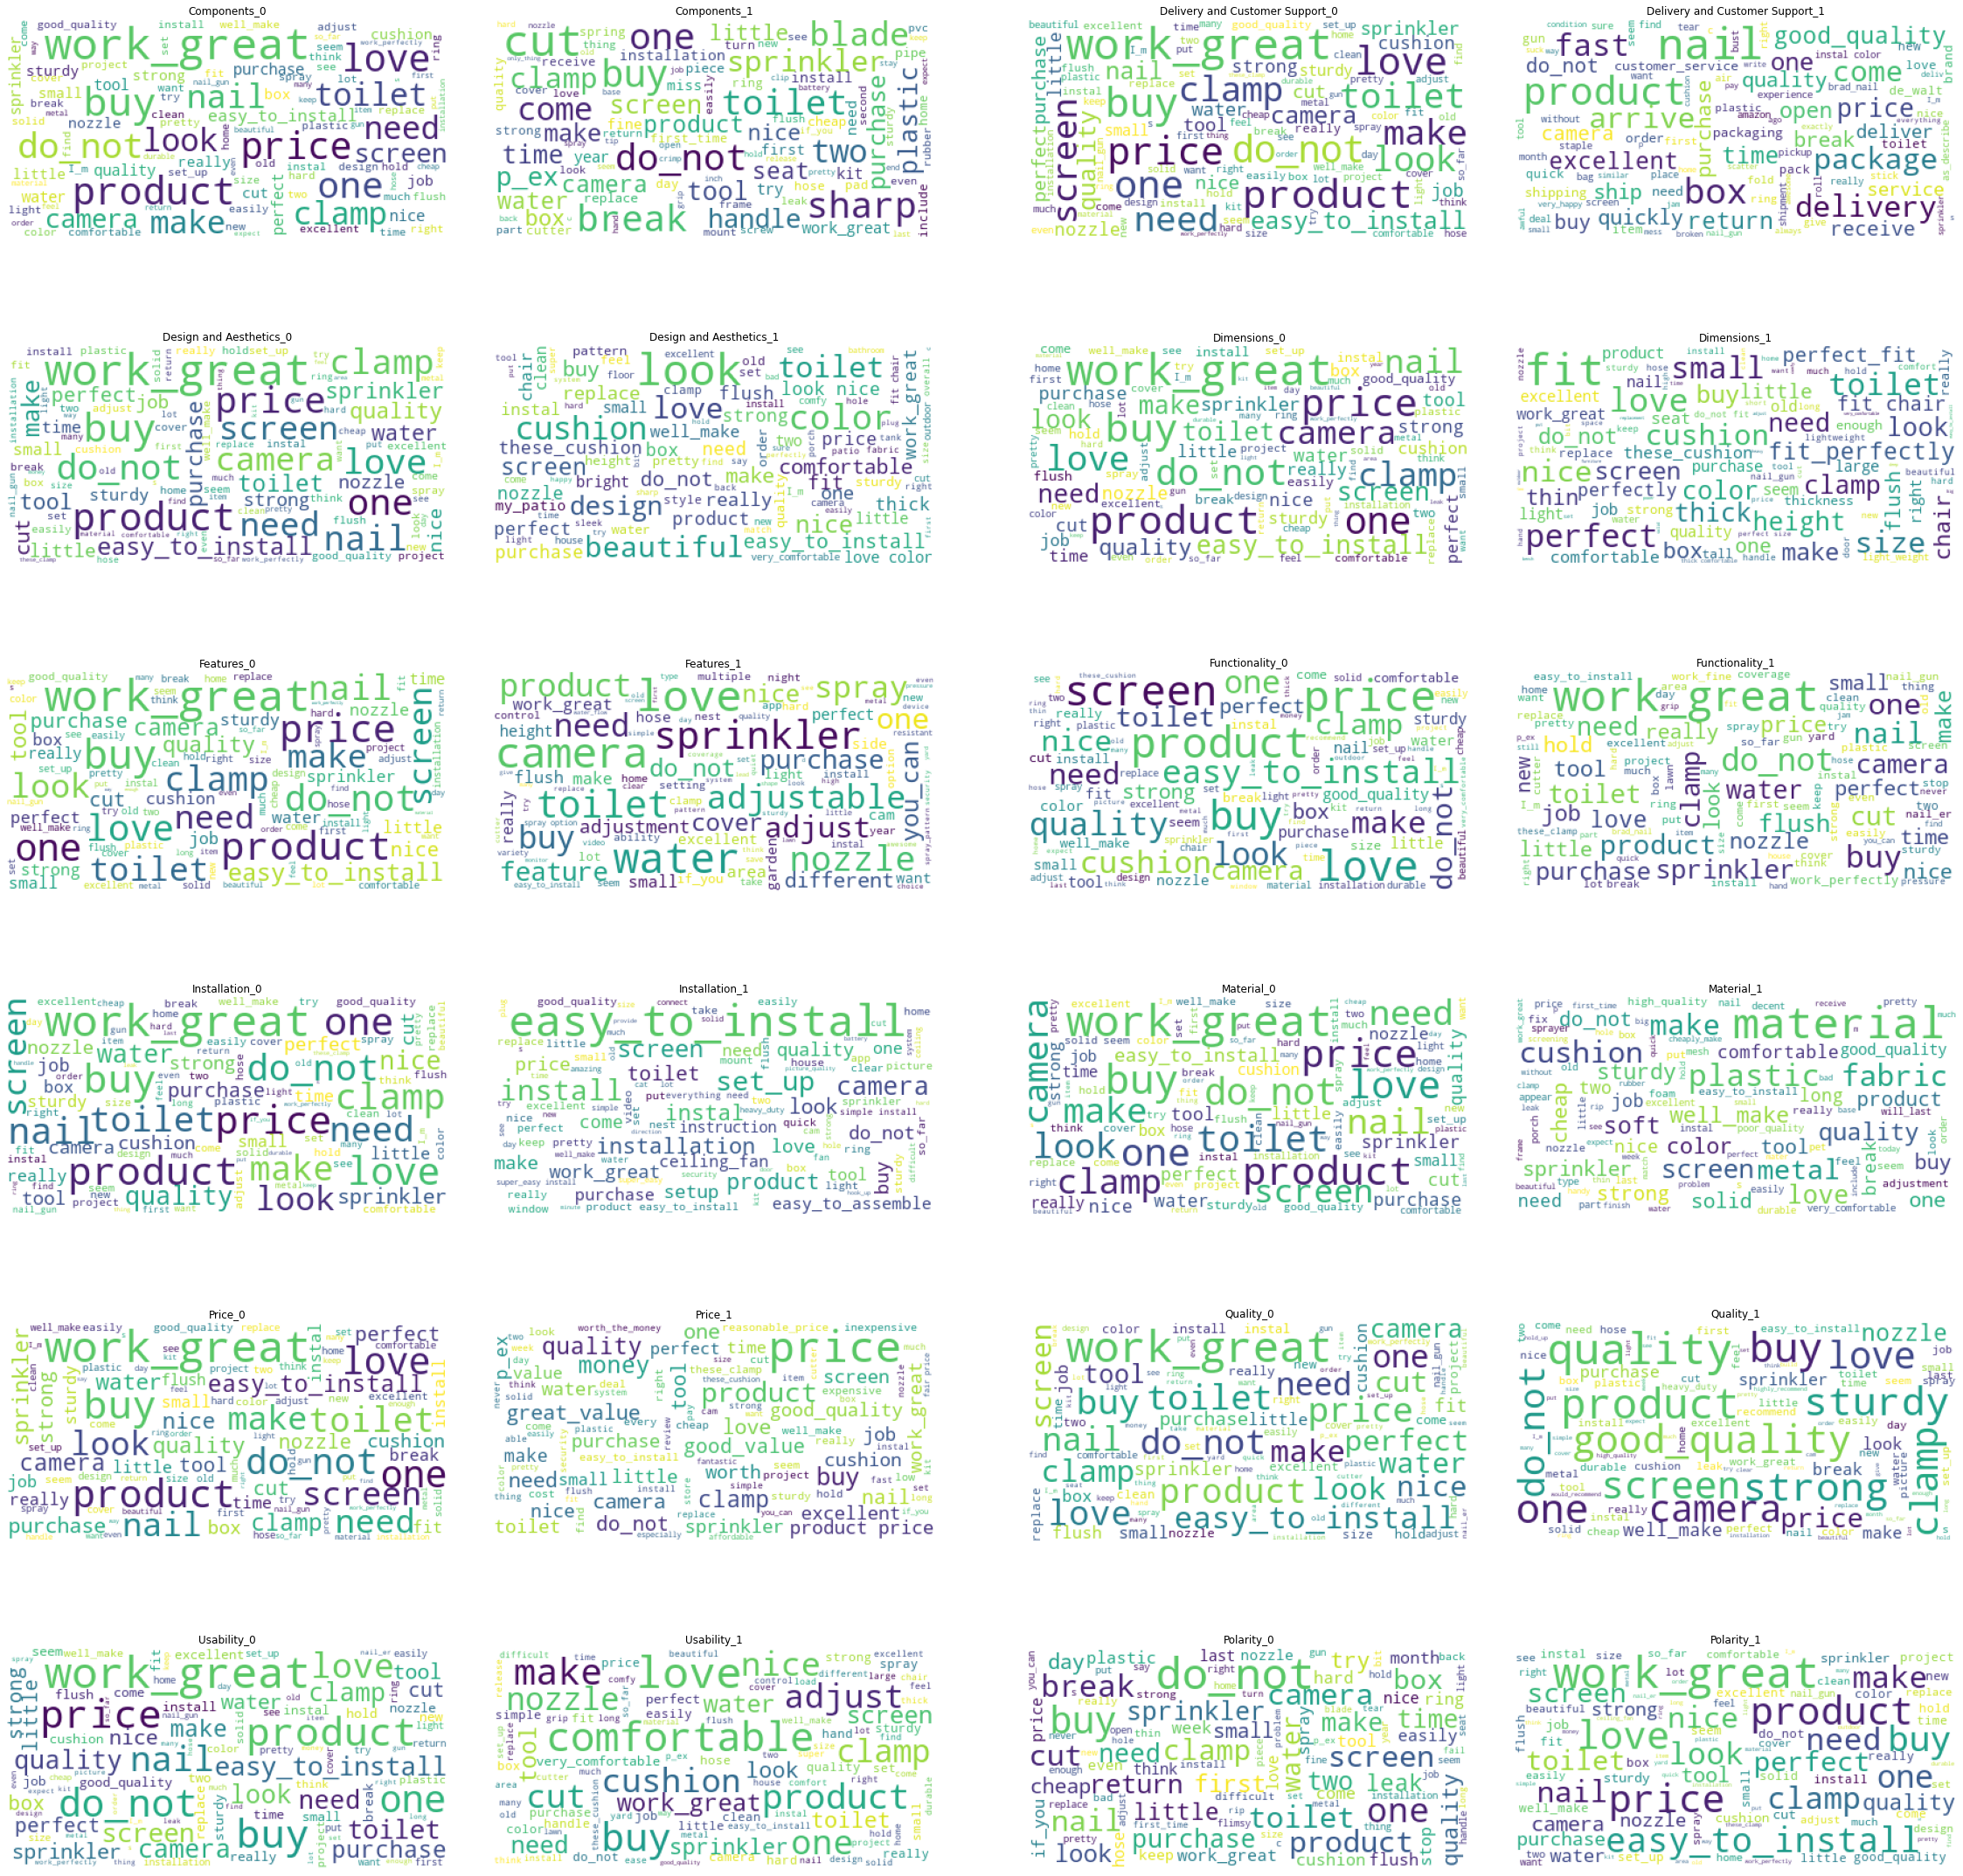

In [6]:
wc_df = pd.concat([df_train, y_train], axis=1)
fig = plt.figure(figsize=(40, 40),constrained_layout=True)
outer = gridspec.GridSpec(6, 2, wspace=0.1, hspace=0.2)

for i,col  in enumerate(wc_df.iloc[:,6:].columns.values):
    inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                    subplot_spec=outer[i], wspace=0.1, hspace=0.1
                    )
    for x in wc_df[col].unique():    
        ax = plt.Subplot(fig, inner[x])
        wc = WordCloud(background_color="white", max_words=100,
                    max_font_size=40, random_state=42).generate(wc_df[wc_df[col]==x]['bigram_tokens'].to_string())
        fig.add_subplot(ax)
        plt.imshow(wc)
        ax.set_title(f"{col}_{x}")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)
#         fig.tight_layout()   

### Embaddings

#### Tf-Idf

In [7]:
tfidf_vectorizer = TfidfVectorizer()
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(df_train['bigram_tokens']) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(df_test['bigram_tokens'])

#### Word2Vec

In [8]:
w2v_model = Word2Vec(min_count=3,
                     window=4,
                     vector_size =300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=30,
                     sg=1,
                     workers=3)
w2v_model.build_vocab(df_train.bi_w2v, progress_per=10000)
w2v_model.train(df_train.bi_w2v, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(835191, 2284530)

In [9]:
len(w2v_model.wv.index_to_key)

2473

In [10]:
w2v_model.wv.most_similar(positive=["recommend"],topn=10)

[('pleased', 0.963977575302124),
 ('would_definitely', 0.9636304974555969),
 ('would_highly', 0.9620240330696106),
 ('value', 0.9549627900123596),
 ('so_far', 0.9536213874816895),
 ('family', 0.9511330723762512),
 ('excellent', 0.9493433237075806),
 ('product', 0.9447338581085205),
 ('quality', 0.9437805414199829),
 ('very_happy', 0.939841091632843)]

In [11]:
# Store the vectors for train data in following file
def avg_w2v_vec(data,st = 'train'):
    word2vec_filename =   './'+st+'_review_word2vec.csv'
    with open(word2vec_filename, 'w+') as word2vec_file:
        for index, row in data.iterrows():
            model_vector = (np.mean([w2v_model.wv.get_vector(token) for token in row['bi_w2v'] if token 
                                     in w2v_model.wv.index_to_key], axis=0)).tolist()
            if index == 0:
                header = ",".join(str(ele) for ele in range(300))
                word2vec_file.write(header)
                word2vec_file.write("\n")

            # check for text in sentence
            if type(model_vector) is list:  
                line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
            else:
                line1 = ",".join([str(0) for i in range(300)])
            word2vec_file.write(line1)
            word2vec_file.write('\n')

avg_w2v_vec(df_train,st = 'train')
avg_w2v_vec(df_test,st = 'test')

C:\Users\saido\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\saido\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [12]:
w2v_df_train = pd.read_csv('train_review_word2vec.csv')
w2v_df_train = w2v_df_train.fillna(0)
w2v_df_test  = pd.read_csv('test_review_word2vec.csv')
w2v_df_test = w2v_df_test.fillna(0)

In [13]:
w2v_df_test.shape, w2v_df_train.shape

((614, 300), (5522, 300))

### pre trained model

In [ ]:
### Resource issue not able to work on this, working very slow when I load it

#### BERT

In [ ]:
### Implimented in Google Colab

### Model Building

#### Cutom Grid search

##### Logistic Regression

In [14]:
# logistic final #C =10
# tf-idf
clf_tfIdf = LogisticRegression(C=10)
model_tfIdf = MultiOutputClassifier(estimator=clf_tfIdf)
model_tfIdf.fit(X_train_vectors_tfidf.toarray(), y_train.values)
y_pred_lr = model_tfIdf.predict(X_test_vectors_tfidf)

C:\Users\saido\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
clf_tfIdf

LogisticRegression(C=10)

In [16]:
LogLoss = []
for i, j in enumerate(y_test.columns):
    print('{} -- logg loss : {}'.format(j,log_loss(y_test.values[:,i],y_pred_lr[:,i])))
#     print(classification_report(y_test.values[:,i],y_pred_lr[:,i]))
    LogLoss.append(log_loss(y_test.values[:,i],y_pred_lr[:,i]))

Components -- logg loss : 1.687564969124074
Delivery and Customer Support -- logg loss : 0.7312796291998368
Design and Aesthetics -- logg loss : 1.7438235593228715
Dimensions -- logg loss : 2.0813438458929774
Features -- logg loss : 1.8563238101331818
Functionality -- logg loss : 7.650358251398703
Installation -- logg loss : 1.5750647183137632
Material -- logg loss : 0.5625207881907286
Price -- logg loss : 1.8563251124091267
Quality -- logg loss : 5.006470176347991
Usability -- logg loss : 6.750285922015192
Polarity -- logg loss : 3.937701515200727


In [17]:
#w2v
clf_w2v = LogisticRegression(C=100,max_iter=800)
model_w2v = MultiOutputClassifier(estimator=clf_w2v)
model_w2v.fit(w2v_df_train.values, y_train.values)
y_pred_lr_w2v = model_w2v.predict(w2v_df_test.values)

In [18]:
LogLoss_w2v = []
for i, j in enumerate(y_test.columns):
    print('{} -- logg loss : {}'.format(j,log_loss(y_test.values[:,i],y_pred_lr_w2v[:,i])))
#     print(classification_report(y_test.values[:,i],y_pred_lr_w2v[:,i]))
    LogLoss_w2v.append(log_loss(y_test.values[:,i],y_pred_lr_w2v[:,i]))

Components -- logg loss : 2.1938388875995085
Delivery and Customer Support -- logg loss : 0.7875317080189096
Design and Aesthetics -- logg loss : 2.081333427685418
Dimensions -- logg loss : 2.9251185167993445
Features -- logg loss : 1.9125732844003647
Functionality -- logg loss : 7.7065986097342725
Installation -- logg loss : 2.9251211213512343
Material -- logg loss : 0.7875304057429646
Price -- logg loss : 3.2063723995149833
Quality -- logg loss : 9.619178405514361
Usability -- logg loss : 6.975273400876363
Polarity -- logg loss : 4.162709830477018


In [19]:
result_df= pd.DataFrame()
result_df['Topics'] = y_train.columns.tolist()
result_df['LR_tf-df'] = LogLoss
result_df['LR_w2v'] = LogLoss_w2v
result_df['LR_tf-df_pram'] = clf_tfIdf
result_df['LR_w2v_pram'] = clf_w2v

In [20]:
result_df.head()

Topics  LR_tf-df    LR_w2v  \
0                     Components  1.687565  2.193839   
1  Delivery and Customer Support  0.731280  0.787532   
2          Design and Aesthetics  1.743824  2.081333   
3                     Dimensions  2.081344  2.925119   
4                       Features  1.856324  1.912573   

              LR_tf-df_pram                              LR_w2v_pram  
0  LogisticRegression(C=10)  LogisticRegression(C=100, max_iter=800)  
1  LogisticRegression(C=10)  LogisticRegression(C=100, max_iter=800)  
2  LogisticRegression(C=10)  LogisticRegression(C=100, max_iter=800)  
3  LogisticRegression(C=10)  LogisticRegression(C=100, max_iter=800)  
4  LogisticRegression(C=10)  LogisticRegression(C=100, max_iter=800)

#### Naive Bayes

In [21]:
#Naive Bayes final
NB_tfidf = GaussianNB(var_smoothing=1)
model_NB = MultiOutputClassifier(estimator=NB_tfidf)
model_NB.fit(X_train_vectors_tfidf.toarray(), y_train.values)
y_pred_NB = model_NB.predict(X_test_vectors_tfidf.toarray())

In [22]:
LogLoss_NB = []
for i, j in enumerate(y_test.columns):
    print('{} -- logg loss : {}'.format(j,log_loss(y_test.values[:,i],y_pred_NB[:,i])))
#     print(classification_report(y_test.values[:,i],y_pred_NB[:,i]))
    LogLoss_NB.append(log_loss(y_test.values[:,i],y_pred_NB[:,i]))
result_df['NB'] = LogLoss_NB
result_df['NB_parm'] = NB_tfidf

Components -- logg loss : 4.894033737058982
Delivery and Customer Support -- logg loss : 15.188412895654784
Design and Aesthetics -- logg loss : 11.250671009899763
Dimensions -- logg loss : 12.994531032949093
Features -- logg loss : 5.0627886712402566
Functionality -- logg loss : 7.6503647627784295
Installation -- logg loss : 14.682132465799624
Material -- logg loss : 20.251215891930432
Price -- logg loss : 22.95137688221534
Quality -- logg loss : 6.3003226847763525
Usability -- logg loss : 10.744345000386533
Polarity -- logg loss : 4.331494717005026


In [23]:
#w2v
NB_w2v = GaussianNB(var_smoothing=10000000000)
model_NB_w2v = MultiOutputClassifier(estimator=NB_w2v)
model_NB_w2v.fit(w2v_df_train.values, y_train.values)
y_pred_NB_w2v = model_NB_w2v.predict(w2v_df_test.values)

In [24]:
LogLoss_NB_w2v = []
for i, j in enumerate(y_test.columns):
    print('{} -- logg loss : {}'.format(j,log_loss(y_test.values[:,i],y_pred_NB_w2v[:,i])))
#     print(classification_report(y_test.values[:,i],y_pred_NB_w2v[:,i]))
    LogLoss_NB_w2v.append(log_loss(y_test.values[:,i],y_pred_NB_w2v[:,i]))
result_df['NB_w2v'] = LogLoss_NB_w2v
result_df['NB_w2v_parm'] = NB_w2v

Components -- logg loss : 2.0250748374866205
Delivery and Customer Support -- logg loss : 0.6750249458288742
Design and Aesthetics -- logg loss : 2.9251080985917843
Dimensions -- logg loss : 3.7688892808778767
Features -- logg loss : 1.8563186010294024
Functionality -- logg loss : 14.119271783587266
Installation -- logg loss : 4.331410069068604
Material -- logg loss : 0.7312770246479469
Price -- logg loss : 5.175191251354695
Quality -- logg loss : 12.76922189192952
Usability -- logg loss : 7.5940306405748235
Polarity -- logg loss : 7.65045982892241


#### Randome Forest

In [25]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
# Number of features to consider at every split
# max_features = ['auto']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 60, num = 2)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [4, 6]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]

In [26]:
random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap
              }

In [ ]:
#grid
st = time.time()
Best_param3 = {}
for num, cls in tqdm(enumerate(y_train.columns.tolist()[:1])): 
    rf = RandomForestClassifier(random_state=42)
    grid_clf_acc1 = GridSearchCV(rf, param_grid = random_grid,scoring = 'neg_log_loss')
    grid_clf_acc1.fit(X_train_vectors_tfidf.toarray(), y_train.values[:,num])
    Best_param3[cls] = [grid_clf_acc1.best_estimator_,'RF']
print((time.time() - st)/60)

In [312]:
#Random Forest final #500
st = time.time()
rf = RandomForestClassifier(random_state=42, n_estimators=300, max_features='auto',max_depth=20,
                           min_samples_split=6,min_samples_leaf=4)
model_rf = MultiOutputClassifier(estimator=rf)
model_rf.fit(X_train_vectors_tfidf.toarray(), y_train.values)
y_pred_rf = model_rf.predict(X_test_vectors_tfidf.toarray())
print((time.time() - st)/60)

6.132607269287109


In [314]:
LogLoss_rf = []
for i, j in enumerate(y_test.columns):
    print('{} -- logg loss : {}'.format(j,log_loss(y_test.values[:,i],y_pred_rf[:,i])))
    print(classification_report(y_test.values[:,i],y_pred_rf[:,i]))
    LogLoss_rf.append(log_loss(y_test.values[:,i],y_pred_rf[:,i]))
result_df['RF'] = LogLoss_rf

Components -- logg loss : 1.5188061281149656
Delivery and Customer Support -- logg loss : 0.8437811822860926
Design and Aesthetics -- logg loss : 3.4876288867825123
Dimensions -- logg loss : 3.9376455173350946
Features -- logg loss : 1.8563186010294024
Functionality -- logg loss : 8.10031758180971
Installation -- logg loss : 4.303284029659068
Material -- logg loss : 0.9000332611051651
Price -- logg loss : 4.7814266996211865
Quality -- logg loss : 9.47847723442768
Usability -- logg loss : 6.77837549769827
Polarity -- logg loss : 7.734839900564938


In [322]:
result_df

Topics        LR         NB        RF
0                      Components  1.462558   4.106486  1.518806
1   Delivery and Customer Support  0.562521  10.125609  0.843781
2           Design and Aesthetics  2.306348   9.534941  3.487629
3                      Dimensions  2.165717  10.097475  3.937646
4                        Features  1.603188   3.853344  1.856319
5                   Functionality  5.569007   6.722211  8.100318
6                    Installation  1.490687  13.978963  4.303284
7                        Material  0.675027  16.707254  0.900033
8                           Price  1.996959  22.754491  4.781427
9                         Quality  4.668958   5.597128  9.478477
10                      Usability  2.728242  14.653998  6.778375
11                       Polarity  4.472111   5.794089  7.734840

### Sentiment Analysis with - Vader

### Logistic regression Log loss is far better than Vader Rule based model

In [131]:
# pip install vaderSentiment

In [337]:
senti_train_df = pd.concat([df_train,y_train], axis=1)
senti_test_df = pd.concat([df_test,y_test], axis=1)

In [346]:
senti_train_df.head(1)

Review  \
0  For some reason everybody complains and I'm co...   

                                        preprocessed  \
0  for some reason everybody complains and im com...   

                                            prep_lem  \
0  [for, some, reason, everybody, complain, and, ...   

                                       bigram_tokens  \
0  reason everybody complain I_m complain toilet ...   

                                      trigram_tokens  \
0  reason everybody complain complain toilet buy ...   

                                              bi_w2v  Components  \
0  [reason, everybody, complain, I_m, complain, t...           0   

   Delivery and Customer Support  Design and Aesthetics  Dimensions  Features  \
0                              0                      0           0         0   

   Functionality  Installation  Material  Price  Quality  Usability  Polarity  
0              0             0         0      0        0          1         0

In [342]:
comment_words1 = [j for i in senti_train_df.bigram_tokens.values for j in i if not len(j)>2 ]
stop_wrd_li1 = [re.sub('[^a-z]','',i) for i in stopwords.words('english')] + comment_words1

In [ ]:
senti_df = senti_train_df[['prep_lem','Polarity']]
senti_df.loc[:,'bigram_tokens'] = senti_df['prep_lem'].apply(lambda x: bigram_mod[x])
senti_df.loc[:,'trigram_tokens'] = senti_df['prep_lem'].apply(lambda x: trigram_mod[x])

senti_test_df1 = senti_test_df[['prep_lem','Polarity']]
senti_test_df1.loc[:,'bigram_tokens'] = senti_test_df1['prep_lem'].apply(lambda x: bigram_mod[x])
senti_test_df1.loc[:,'trigram_tokens'] = senti_test_df1['prep_lem'].apply(lambda x: trigram_mod[x])

In [ ]:
senti_df = stop_word(senti_df,stop_wrd_li1)

senti_test_df1 = stop_word(senti_test_df1,stop_wrd_li1)

In [10]:
senti_df =pd.read_pickle("senti_df.pkl")  
senti_test_df1 =pd.read_pickle("senti_test_df.pkl")  

In [39]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
updates = {'work_great': 3 , 'easy_to_install':2, 'good_quality':3, 'work well':2, 'well':2, 'like':3}
def sentiment(sentence):
    pos = []
    sid_obj = SentimentIntensityAnalyzer()
    sid_obj.lexicon.update(updates)
    sentiment_dict = sid_obj.polarity_scores(sentence)
    return sentiment_dict['pos'], sentiment_dict['neg'] ,sentiment_dict['compound']

In [12]:
senti_df['Pos', 'Neg', 'Compound'] = senti_df['bigram_tokens'].progress_apply(lambda x: sentiment(x))
senti_test_df1['Pos', 'Neg', 'Compound'] = senti_test_df1['bigram_tokens'].progress_apply(lambda x: sentiment(x))

100%|██████████| 5522/5522 [01:15<00:00, 73.03it/s]


In [21]:
def senti(x):
    if( (x[2]>=0.5)|(x[0]>=0.4)):
        return 1
    elif x[2]<0.5:
        return 0

In [26]:
senti_df['Sentiment'] = senti_df[('Pos', 'Neg', 'Compound')].apply(senti)
senti_test_df1['Sentiment'] = senti_test_df1[('Pos', 'Neg', 'Compound')].apply(senti)
log_loss(senti_df['Polarity'],senti_df['Sentiment'])
log_loss(senti_test_df1['Polarity'],senti_test_df1['Sentiment'])

8.775382898192875

#### Summary